Compare climate feedback processes between Winton & Semtner 0L, ICON-A

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from os import path
import sys, importlib
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes

from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from scipy import integrate

sys.path.append("../../python_packages")
import ICON_tools
import EBMs
importlib.reload(ICON_tools)
importlib.reload(EBMs)

<module 'EBMs' from '../../python_packages/EBMs.py'>

In [2]:
data_path="/jetfs/scratch/jhoerner/postprocessing"
explist_W, nexp_W = ICON_tools.get_explist(data_path, ["ape_ia_8000_90_3W", "ape_ia_8500_90_3W"]) # , "ape_ia_7000_56_3W", "ape_ia_9000_90_3W", "ape_ia_15000_17_3W"
explist_S, nexp_S = ICON_tools.get_explist(data_path, ["ape_ia_5000_13_0S", "ape_ia_5500_90_0S"]) # , "ape_ia_6000_90_0S",  "ape_ia_6500_90_0S" , "ape_ia_7000_62_0S", "ape_ia_6000_90_0S_cltlim_dtime10", "ape_ia_6500_90_0S_cltlim_dtime10", "ape_ia_8000_13_0S", "ape_ia_9000_13_0S", "ape_ia_10000_13_0S" 


DSlistgm_W_decode=np.empty([nexp_W],dtype="object")
DSlistgm_W=np.empty([nexp_W],dtype="object")
DSlistzm_W_decode=np.empty([nexp_W],dtype="object")
DSlistgmym_W=np.empty([nexp_W],dtype="object")
DSlistzmym_W=np.empty([nexp_W],dtype="object")

DSlistgm_W, _ =ICON_tools.load_ds_2d(data_path,explist_W)

DSlistgm_S_decode=np.empty([nexp_S],dtype="object")
DSlistgm_S=np.empty([nexp_S],dtype="object")
DSlistzm_S_decode=np.empty([nexp_S],dtype="object")
DSlistgmym_S=np.empty([nexp_S],dtype="object")
DSlistzmym_S=np.empty([nexp_S],dtype="object")

DSlistgm_S, _ =ICON_tools.load_ds_2d(data_path,explist_S)

# load the data again with decoded times, as decoding afterwards doesn't seem to work...
DSlistgm_W_decode, DSlistzm_W_decode=ICON_tools.load_ds_2d(data_path,explist_W, True)
DSlistgm_S_decode, DSlistzm_S_decode=ICON_tools.load_ds_2d(data_path,explist_S, True)


for i in range(nexp_W):
    #fillna 
    DSlistzm_W_decode[i] = DSlistzm_W_decode[i].where(DSlistgm_W_decode[i]['sic'] < 1e36)
    DSlistgm_W[i] = DSlistgm_W[i].where(DSlistgm_W[i]['sic'] < 1e36)  
    DSlistgm_W_decode[i] = DSlistgm_W_decode[i].where(DSlistgm_W_decode[i]['sic'] < 1e36)
    
    print(explist_W[i] +" yearly mean")
    DSlistgmym_W[i]=xr.decode_cf(DSlistgm_W_decode[i]).groupby('time.year').mean(dim='time', skipna=False)
    DSlistzmym_W[i]=xr.decode_cf(DSlistzm_W_decode[i]).groupby('time.year').mean(dim='time', skipna=False)
    
for i in range(nexp_S):
    #fillna 
    DSlistzm_S_decode[i] = DSlistzm_S_decode[i].where(DSlistgm_S_decode[i]['sic'] < 1e36)  
    DSlistgm_S[i] = DSlistgm_S[i].where(DSlistgm_S[i]['sic'] < 1e36)  
    DSlistgm_S_decode[i] = DSlistgm_S_decode[i].where(DSlistgm_S_decode[i]['sic'] < 1e36)  
    
    print(explist_S[i] +" yearly mean")
    DSlistgmym_S[i]=xr.decode_cf(DSlistgm_S_decode[i]).groupby('time.year').mean(dim='time', skipna=False)
    DSlistzmym_S[i]=xr.decode_cf(DSlistzm_S_decode[i]).groupby('time.year').mean(dim='time', skipna=False)
    



colorlist=["C1","C0","C2","C3","C5","C6","C7"]
linestylelist=["-","--",":"]




ape_ia_8000_90_3W: directory is /jetfs/scratch/jhoerner/postprocessing/ape_ia_8000_90_3W
ape_ia_8500_90_3W: directory is /jetfs/scratch/jhoerner/postprocessing/ape_ia_8500_90_3W
ape_ia_5000_13_0S: directory is /jetfs/scratch/jhoerner/postprocessing/ape_ia_5000_13_0S
ape_ia_5500_90_0S: directory is /jetfs/scratch/jhoerner/postprocessing/ape_ia_5500_90_0S
ape_ia_8000_90_3W yearly mean
ape_ia_8500_90_3W yearly mean
ape_ia_5000_13_0S yearly mean
ape_ia_5500_90_0S yearly mean


## albedo binning, plotting in dependece of ice-edge latitude 

In [3]:
simind1 = explist_S.index('ape_ia_5500_90_0S')
simind2 = explist_S.index('ape_ia_5000_13_0S')

simind1_W = explist_W.index('ape_ia_8000_90_3W')
simind2_W = explist_W.index('ape_ia_8500_90_3W')


DS1 = DSlistzm_S_decode[simind1].squeeze().isel(time=slice(12, -12)).copy()
DS2 = DSlistzm_S_decode[simind2].squeeze().isel(time=slice(12, -12)).copy()

DSW1 = DSlistzm_W_decode[simind1_W].squeeze().isel(time=slice(12, -12)).copy()
DSW2 = DSlistzm_W_decode[simind2_W].squeeze().isel(time=slice(12, -12)).copy()

lat = DS1.lat.squeeze().values
icelat_combined = np.append(ICON_tools.sictoicelat(DSlistgm_S_decode[simind1].sic.isel(time=slice(12, -12)).squeeze().values), ICON_tools.sictoicelat(DSlistgm_S_decode[simind2].sic.isel(time=slice(12, -12)).squeeze().values))
icelat = ICON_tools.sictoicelat(DSlistgm_S_decode[simind1].sic.squeeze().isel(time=slice(12, -12)).values)


icelatW_combined = np.append(ICON_tools.sictoicelat(DSlistgm_W_decode[simind1_W].sic.isel(time=slice(12, -12)).squeeze().values), ICON_tools.sictoicelat(DSlistgm_W_decode[simind2_W].sic.isel(time=slice(12, -12)).squeeze().values))
icelatW = ICON_tools.sictoicelat(DSlistgm_W_decode[simind1_W].sic.squeeze().isel(time=slice(12, -12)).values)



In [4]:
hist, bin_edges = np.histogram(icelat, bins=int(np.size(lat)/2), range=(0, 90))
bins = (bin_edges[1:]+bin_edges[:-1])/2
ind = np.digitize(icelat, bins=bin_edges[:-1], right=False) # right=False means 

hist_combined, bin_edges_combined = np.histogram(icelat_combined, bins=int(np.size(lat)/2), range=(0, 90))
bins_combined = (bin_edges_combined[1:]+bin_edges_combined[:-1])/2
ind_combined = np.digitize(icelat_combined, bins=bin_edges_combined[:-1], right=False) # right=False means 

histW, bin_edgesW = np.histogram(icelatW, bins=int(np.size(lat)/2), range=(0, 90))
binsW = (bin_edgesW[1:]+bin_edgesW[:-1])/2
indW = np.digitize(icelatW, bins=bin_edgesW[:-1], right=False) # right=False means

histW_combined, bin_edgesW_combined = np.histogram(icelatW_combined, bins=int(np.size(lat)/2), range=(0, 90))
binsW_combined = (bin_edgesW_combined[1:]+bin_edgesW_combined[:-1])/2
indW_combined = np.digitize(icelatW_combined, bins=bin_edgesW_combined[:-1], right=False) # right=False means

In [5]:
#sanity check
#for n in range(np.size(icelat_combined)):
#    print(bin_edges[ind_combined[n]-1], "<=", icelat_combined[n], "<", bin_edges[ind_combined[n]])

In [6]:
def calc_bins(array, bins, inds):
    array_binned=np.empty((np.shape(bins)[0], np.shape(array)[1]))

    for i in range(np.size(bins)):
        array_binned[i,:] = np.nanmean(array[inds==i+1], axis=0) # average ice lat of all points in each icelat bin, is basically a straight line

    a, b = np.hsplit(array_binned,2)
    return (np.fliplr(b)+a)/2

In [7]:
icelat_binned=np.empty(np.shape(bins))
icelat_binned[:]=np.nan
a, b = np.hsplit(lat,2)

lat_split = (abs(a)+abs(np.flip(b)))/2


albedo_combined_binned=calc_bins(np.append(ICON_tools.get_albedo(DS1,"toa").squeeze().values, ICON_tools.get_albedo(DS2,"toa").squeeze().values, axis=0) , bins_combined, ind_combined)
hs_combined_binned=calc_bins(np.append(DS1.hs_icecl.squeeze().values, DS2.hs_icecl.squeeze().values, axis=0) , bins_combined, ind_combined)
qtop_combined_binned=calc_bins(np.append(DS1.qtop_icecl.squeeze().values - DS1.fluxres_i_icecl.squeeze().values , DS2.qtop_icecl.squeeze().values - DS2.fluxres_i_icecl.squeeze().values, axis=0) , bins_combined, ind_combined)
prsnow_combined_binned=calc_bins(np.append(DS1.prls.squeeze().values+DS1.prcs.squeeze().values, DS2.prls.squeeze().values+DS2.prcs.squeeze().values, axis=0) , bins_combined, ind_combined)
prrain_combined_binned=calc_bins(np.append(DS1.prlr.squeeze().values+DS1.prcr.squeeze().values, DS2.prlr.squeeze().values+DS2.prcr.squeeze().values, axis=0) , bins_combined, ind_combined)
evap_combined_binned=calc_bins(np.append(DS1.evspsbl.squeeze().values, DS2.evspsbl.squeeze().values, axis=0) , bins_combined, ind_combined)


albedoW_combined_binned=calc_bins(np.append(ICON_tools.get_albedo(DSW1,"toa").squeeze().values, ICON_tools.get_albedo(DSW2,"toa").squeeze().values, axis=0) , binsW_combined, indW_combined)
hsW_combined_binned=calc_bins(np.append(DSW1.hs_icecl.squeeze().values, DSW2.hs_icecl.squeeze().values, axis=0) , binsW_combined, indW_combined)
qtopW_combined_binned=calc_bins(np.append(DSW1.qtop_icecl.squeeze().values - DSW1.fluxres_i_icecl.squeeze().values, DSW2.qtop_icecl.squeeze().values - DSW2.fluxres_i_icecl.squeeze().values, axis=0) , binsW_combined, indW_combined)
qbotW_combined_binned=calc_bins(np.append(DSW1.qbot_icecl.squeeze().values, DSW2.qbot_icecl.squeeze().values, axis=0) , binsW_combined, indW_combined)
prsnowW_combined_binned=calc_bins(np.append(DSW1.prls.squeeze().values+DSW1.prcs.squeeze().values, DSW2.prls.squeeze().values+DSW2.prcs.squeeze().values, axis=0) , binsW_combined, indW_combined)
prrainW_combined_binned=calc_bins(np.append(DSW1.prlr.squeeze().values+DSW1.prcr.squeeze().values, DSW2.prlr.squeeze().values+DSW2.prcr.squeeze().values, axis=0) , binsW_combined, indW_combined)
evapW_combined_binned=calc_bins(np.append(DSW1.evspsbl.squeeze().values, DSW2.evspsbl.squeeze().values, axis=0) , binsW_combined, indW_combined)


/jetfs/home/jhoerner/.conda/envs/baseenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/jetfs/home/jhoerner/.conda/envs/baseenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


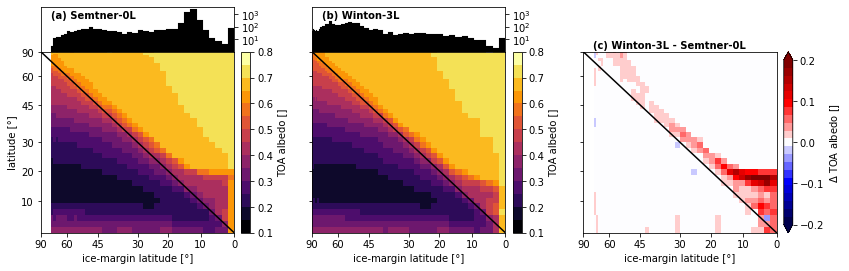

In [8]:
fig, ax = plt.subplots(1,3, figsize=(12,4), sharex=True, sharey=True)
levels=np.linspace(0.1,0.8,15)
cmap = plt.colormaps['inferno']
norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)

levels_diff=np.linspace(-0.2,0.2,22)
cmap_diff = plt.colormaps['seismic']
norm_diff = mpl.colors.BoundaryNorm(levels_diff, ncolors=cmap_diff.N, clip=True)

im0 = ax[0].pcolormesh(ICON_tools.icelatosic(bins_combined), 1-ICON_tools.icelatosic(lat_split), albedo_combined_binned.T, norm=norm, cmap=cmap, linewidth=0,rasterized=True)
im1 = ax[1].pcolormesh(ICON_tools.icelatosic(bins_combined), 1-ICON_tools.icelatosic(lat_split), albedoW_combined_binned.T, norm=norm, cmap=cmap, linewidth=0,rasterized=True)
im2 = ax[2].pcolormesh(ICON_tools.icelatosic(bins_combined), 1-ICON_tools.icelatosic(lat_split), albedoW_combined_binned.T-albedo_combined_binned.T, norm=norm_diff, cmap=cmap_diff, linewidth=0,rasterized=True)
im0.set_edgecolor('face')
im1.set_edgecolor('face')
im2.set_edgecolor('face')

plt.colorbar(im0,ax=ax[0], label="TOA albedo []", pad=0.03)
plt.colorbar(im1,ax=ax[1], label="TOA albedo []", pad=0.03)
plt.colorbar(im2,ax=ax[2], label="$\Delta$ TOA albedo []", extend="both", ticks=np.linspace(-0.2,0.2,5), pad=0.03)


widtharray = (ICON_tools.icelatosic(bin_edges_combined)[:-1]-ICON_tools.icelatosic(bin_edges_combined)[1:])#+0.002
ax_hist = np.empty(2, dtype="object")
ax_hist[0]=ax[0].inset_axes([0, 1.0, 1, 0.25])
ax_hist[0].bar(ICON_tools.icelatosic(bins_combined), hist_combined, width=widtharray, color="black", edgecolor="black", linewidth=0.1)
ax_hist[1]=ax[1].inset_axes([0, 1.0, 1, 0.25], sharex=ax_hist[0])
ax_hist[1].bar(ICON_tools.icelatosic(binsW_combined), histW_combined, width=widtharray, color="black", edgecolor="black", linewidth=0.1)
ax_hist[0].spines['bottom'].set_visible(False)
ax_hist[1].spines['bottom'].set_visible(False)
ax_hist[0].set_xticks([])
ax_hist[1].set_xticks([])

ax_hist[0].set_yscale("log")
ax_hist[1].set_yscale("log")
ax_hist[1].set_ylim(1,4000)
ax_hist[0].set_ylim(1,4000)
ax_hist[0].yaxis.tick_right()
ax_hist[1].yaxis.tick_right()
ax[0].set_ylabel("latitude [°]")
ax_hist[0].set_yticks([10,100,1000])
ax_hist[1].set_yticks([10,100,1000])

xticks=[90,60,45,30,20,10,0]

ax_hist[0].annotate("(a) Semtner-0L", xycoords="axes fraction", xy=(0.05,0.75), fontweight="bold")
ax_hist[1].annotate("(b) Winton-3L", xycoords="axes fraction", xy=(0.05,0.75), fontweight="bold")
ax[2].annotate("(c) Winton-3L - Semtner-0L", xycoords="axes fraction", xy=(0.05,1.02), fontweight="bold")

for axind in [0,1,2]:
    ax[axind].set_xticks(ICON_tools.icelatosic(xticks))
    ax[axind].set_xticklabels(xticks)
    ax[axind].set_yticks(1-ICON_tools.icelatosic(xticks))
    ax[axind].set_yticklabels(xticks)
    ax[axind].set_xlabel("ice-margin latitude [°]")

    ax[axind].plot([0,1],[1,0],color="black")


ax[0].set_xlim(ICON_tools.icelatosic(90),1)
ax_hist[0].set_xlim(ICON_tools.icelatosic(90),1)
plt.tight_layout()
plt.savefig("plots/Fig4-toaalb_phase.pdf")
plt.savefig("plots/Fig4-toaalb_phase.png", dpi=300)

In [9]:
density = 1000 # rhoh20 [kgm^-3]
fusion = 333700 # alf = als-alv [Jkg^-1]
spy = 60*60*24*360 # seconds per year

n values for 0S: 2542
n values for 3W: 19


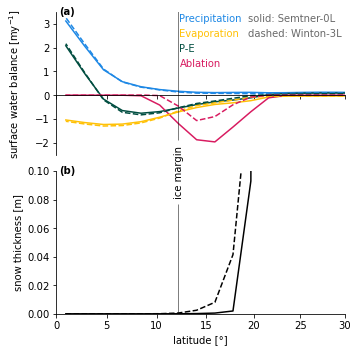

In [48]:
lat_sel = 12.1875
ind_jor = np.squeeze(np.where(bins_combined==lat_sel))
print("n values for 0S: " +str(hist_combined[ind_jor]))
print("n values for 3W: " +str(histW_combined[ind_jor]))

pcolor = "#1E88E5"
ecolor = "#FFC107"
acolor = "#D81B60"
pecolor = "#004D40"
ncolor = "dimgray"
scolor = "black"

colors = [plt.cm.Set1(i) for i in range(5)]

prec_total = spy*(prsnow_combined_binned[ind_jor,:] + prrain_combined_binned[ind_jor,:])/density
prec_snow = spy*(prsnow_combined_binned[ind_jor,:] )/density
evap = -1*spy*(evap_combined_binned[ind_jor,:] )/density
melt = spy*qtop_combined_binned[ind_jor,:]/(fusion*density)
hs = hs_combined_binned[ind_jor,:]


precW_total = spy*(prsnowW_combined_binned[ind_jor,:] + prrainW_combined_binned[ind_jor,:])/density
precW_snow = spy*(prsnowW_combined_binned[ind_jor,:] )/density
evapW = -1*spy*(evapW_combined_binned[ind_jor,:] )/density
meltW = spy*qtopW_combined_binned[ind_jor,:]/(fusion*density)
hsW = hsW_combined_binned[ind_jor,:]



fig, ax = plt.subplots(2,1, figsize=(5,5), sharex=True)

xvals = 1-ICON_tools.icelatosic(lat_split)
#xvals = 1-ICON_tools.icelatosic(np.flipud(bin_edges[:-1]))

l1 = ax[0].plot(xvals, prec_total, c=pcolor)
l2 = ax[0].plot(xvals, -1*evap, c=ecolor)
l3 = ax[0].plot(xvals, prec_total-evap, c=pecolor)
l4 = ax[0].plot(xvals, -1*melt, c=acolor)

ax[0].plot(xvals, precW_total, c=pcolor, ls="--")
ax[0].plot(xvals, -1*evapW, c=ecolor, ls="--")
ax[0].plot(xvals, precW_total-evapW, c=pecolor, ls="--")
ax[0].plot(xvals, -1*meltW, c=acolor, ls="--")

l = plt.Line2D([0], [0], color=ncolor, linewidth=3, linestyle='--') 


legend0 = ax[0].legend(handles = [l1[0], l2[0],l3[0], l4[0]], labels=["Precipitation", "Evaporation",  "P-E", "Ablation"], loc=1, bbox_to_anchor=(0.674, 1.05), ncol=1, edgecolor='none', facecolor='none', labelcolor='linecolor')     
legend1 = ax[0].legend(handles = [l, l], labels=["solid: Semtner-0L", "dashed: Winton-3L"], loc=1, bbox_to_anchor=(1.02, 1.05),ncol=1, edgecolor='none', facecolor='none', labelcolor='linecolor')

for item in legend0.legendHandles:
        item.set_visible(False)
for item in legend1.legendHandles:
        item.set_visible(False)

ax[0].add_artist(legend0)
        
        
            
#plt.plot(-1*melt)

ax[0].vlines(1-ICON_tools.icelatosic(lat_sel), -1.9, 4, color="black", lw=0.5)
#ax.vlines(1-ICON_tools.icelatosic(11.25), -999, 999, color="gray", lw=1)
#ax.vlines(1-ICON_tools.icelatosic(13.125), -999, 999, color="gray", lw=1)
xticks=[30, 25, 20, 15,  10, 5, 0]
ax[0].set_xticks(1-ICON_tools.icelatosic(xticks))
ax[1].set_xticklabels(["30", "25", "20", "15",  "10", "5", "0"])
ax[0].set_ylabel("surface water balance [my$^{-1}$]")
ax[1].set_xlabel("latitude [°]")
ax[0].set_ylim(-2.5,3.5)
ax[1].set_xlim(0,1-ICON_tools.icelatosic(30))

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

ax[0].spines['bottom'].set_position('zero')


ax[1].vlines(1-ICON_tools.icelatosic(lat_sel), -2, 0.077, color="black", lw=0.5)

ax[1].plot(xvals, hs, c=scolor, label="snow thickness (Semtner-0L)")
ax[1].plot(xvals, hsW, c=scolor, label="snow thickness (Winton-3L)", ls="--")
ax[1].set_ylim(0,0.1)
ax[1].set_ylabel("snow thickness [m]")
#x[1].legend(ncol=1)
#plt.annotate("ice margin", xy=(1, 1), xycoords="figure fraction", rotation=90)
fig.text(0.49, 0.51, "ice margin",
         ha='center', va='center', rotation=90, 
         transform=fig.transFigure)



ax[0].annotate("(a)", xycoords="axes fraction", xy=(0.01,0.98), fontweight="bold")
ax[1].annotate("(b)", xycoords="axes fraction", xy=(0.01,0.98), fontweight="bold")








plt.tight_layout()
fig.align_ylabels(ax[:])
plt.savefig("plots/Fig3-PEzonalmean.pdf")